In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import numpy as np
import pandas as pd
import string
import opendatasets as od
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import torch
from torch import nn, optim
import torchtext.data
import torchtext.datasets
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.preprocessing import LabelBinarizer
import transformers
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaModel, ElectraModel, ElectraTokenizer
from transformers import logging
logging.set_verbosity_error()

from torch import cuda
from tqdm.notebook import tqdm
device = 'cuda' if cuda.is_available() else 'cpu'


from collections import Counter as ctr

In [3]:
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('./Sarcasm_Headlines_Dataset.json'))

df =  pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
df.rename(columns={'headline': 'text'}, inplace=True)
df.head()

,article_link,text,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [30]:
links = df['article_link']
links
huffpost = []
onion = []
for link in links:
    if "theonion" in str(link):
        onion.append(link)
    else:
        huffpost.append(link)
        
#huffpost, onion

In [31]:
site = {}
for row in df.article_link:
    if row in huffpost:
        site[row] = "huffpost"
    else:
        site[row] = "onion"

#site

In [32]:
df['site'] = pd.Series(site.values())

In [33]:
df['site'].replace(np.nan, "huffpost", inplace=True)
df['text'] = df['text'].astype(str)

In [34]:
df

,article_link,text,is_sarcastic,site
0,https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sues over secret 'black code' for minority shoppers,0,huffpost
1,https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0,huffpost
2,https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom starting to fear son's web series closest thing she will have to grandchild,1,onion
3,https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1,onion
4,https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,j.k. rowling wishes snape happy birthday in the most magical way,0,huffpost
...,...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-politics-in-moral-free-fall_us_59d7d654e4b0705dc79aa79f,american politics in moral free-fall,0,huffpost
26705,https://www.huffingtonpost.com/entry/americas-best-20-hikes_b_7701574.html,america's best 20 hikes,0,huffpost
26706,https://www.huffingtonpost.com/entry/reparations-and-obama_b_5390741.html,reparations and obama,0,huffpost
26707,https://www.huffingtonpost.com/entry/israeli-ban-alarm_us_58d277f3e4b0b22b0d187dcb,israeli ban targeting boycott supporters raises alarm abroad,0,huffpost


In [10]:
max(df['text'].str.len()), min(df['text'].str.len()), df['text'].str.len().mean()

(254, 7, 60.910591935302705)

In [35]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

In [36]:
lemma = WordNetLemmatizer()
w_tokenizer = WhitespaceTokenizer()

def lemmatize_text(text):
    return ' '.join([lemma.lemmatize(w) for w in w_tokenizer.tokenize(text)])

df['text'] = df['text'].apply(lemmatize_text)
# df

In [37]:
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s
df['text'] = df['text'].apply(remove_punctuation)

## Train/Test Split for MNB Classifier

In [38]:
with open('glasgow_stop_words.txt') as f:
    stops = f.readlines()
f.close()
vec = CountVectorizer(stop_words=stops)
bag_o_words = vec.fit_transform(df['text'])
bag_o_words = np.array(bag_o_words.todense())

/Users/christinepinney/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'ev

In [39]:
X = bag_o_words
y = df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [40]:
model = MultinomialNB().fit(X_train, y_train)
y_pred = model.predict(X_test)

In [41]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.8447923757658271
F1 score: 0.8404750120977831
ROC AUC: 0.8371586644748504


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4942
           1       0.86      0.77      0.81      3872

    accuracy                           0.84      8814
   macro avg       0.85      0.84      0.84      8814
weighted avg       0.85      0.84      0.84      8814



In [43]:
results = pd.DataFrame(data={'predicted': y_pred, 'actual': y_test})
predictions = results.join(df)

In [44]:
def is_correct(predicted, actual):
    if predicted == actual:
        return True
    else:
        return False

predictions['correct'] = predictions.apply(lambda x: is_correct(x.predicted, x.actual), axis=1)
predictions = predictions[['text','predicted','actual','correct']]

In [45]:
pd.set_option('display.max_colwidth', None)

##### looking at where the classifier made correct/incorrect decisions

In [46]:
predictions[predictions['correct']==False].sample(10)

,text,predicted,actual,correct
25973,wisconsin ha crush on minnesota,0,1,False
13138,female author accuse junot diaz of virulent misogyny,1,0,False
12843,bush to iraqi militants please stop bringing it on,0,1,False
20385,obama revise campaign promise of change to relatively minor readjustment in certain favorable policy areas,0,1,False
22384,thing in cave not finished with eric yet,0,1,False
10291,desperate chive marketing board launch big bowl o chive in the mornin campaign,0,1,False
2419,kitten become friend with horse after playing in their hay net,1,0,False
16691,how to be grateful and stop acting like a frustrated toddler,1,0,False
13614,obama delivers whispered untelevised speech on gun control,0,1,False
21430,north american child begin summer migration to dads,0,1,False


In [47]:
predictions[predictions['correct']==True].sample(10)

,text,predicted,actual,correct
8273,nation demand nasa stop holding press conference until they discover some little alien guy,1,1,True
10994,study 38 percent of people not actually entitled to their opinion,1,1,True
10267,congress discontinues festival seating after insurancederegulationbill stampede,1,1,True
12253,beyoncé will reportedly join coldplay for the super bowl 50 halftime show,0,0,True
17022,annoying man more annoying after skydiving,1,1,True
24170,gun are the ultimate public health crisis howard dean tell democratic convention,0,0,True
3798,us still enjoying small but loyal following,1,1,True
18682,sarah palin photo of son stepping on dog trigger online outrage,0,0,True
17448,nyt bloomberg planning independent presidential run,0,0,True
18138,friend from college wasted no time becoming whitecollar professional,1,1,True


## Train/Test Split for ELECTRA

In [48]:
training_data, testing_data = train_test_split(df, test_size = 0.08)

training_data = training_data[['text', 'is_sarcastic']]
testing_data = testing_data[['text', 'is_sarcastic']]

train_y = pd.get_dummies(training_data.is_sarcastic)
test_y = pd.get_dummies(testing_data.is_sarcastic)

train_data = np.array(training_data['text'])
test_data = np.array(testing_data['text'])

train_labels = LabelBinarizer().fit_transform(train_y)
test_labels = LabelBinarizer().fit_transform(test_y)

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((24572,), (24572, 2), (2137,), (2137, 2))

In [49]:
train_data = train_data[:500]
train_labels = train_labels[:500]

test_data = test_data[:100]
test_labels = test_labels[:100]

## Tokenize Data & Define Model

In [50]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

In [51]:
class MultiLabelDataset(torch.utils.data.Dataset):

    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
#             'targets': torch.tensor(self.targets[index], dtype=torch.float)
            'targets': self.targets[index].clone().detach()
        }

In [52]:
class ELECTRA(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(ELECTRA, self).__init__()
                   
#         self.l1 = BertModel.from_pretrained("bert-base-uncased")
#         self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.l1 = ElectraModel.from_pretrained("google/electra-small-discriminator")
        self.classifier = torch.nn.Linear(256, NUM_OUT)
        self.dropout = torch.nn.Dropout(0.5)
#         self.sig = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim=1)
        

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
#         pooler = self.dropout(pooler)
        classifier = self.classifier(pooler)
        dropout = self.dropout(classifier)
#         sig = self.sig(dropout)
        output = self.softmax(dropout)
        return output

In [53]:
def loss_fn(outputs, targets):
    return torch.nn.BCELoss()(outputs, targets)

def train(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss
    
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
    return torch.stack(fin_outputs), torch.stack(fin_targets)

## Train Model

In [54]:
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 4
NUM_OUT = 2
LEARNING_RATE = 2e-05

training_data = MultiLabelDataset(train_data, torch.from_numpy(train_labels), tokenizer, MAX_LEN)
testing_data = MultiLabelDataset(test_data, torch.from_numpy(test_labels), tokenizer, MAX_LEN)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

training_loader = torch.utils.data.DataLoader(training_data, **train_params)
testing_loader = torch.utils.data.DataLoader(testing_data, **test_params)

In [55]:
model = ELECTRA(NUM_OUT)
model.to(device)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    loss = train(model, training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
    guess, targs = validation(model, testing_loader)
    guesses = torch.max(guess, dim=1)
    targets = torch.max(targs, dim=1)
    print('accuracy on test set {}'.format(accuracy_score(guesses.indices, targets.indices)))

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 0, Loss:  0.6585502028465271


  0%|          | 0/13 [00:00<?, ?it/s]

accuracy on test set 0.78


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 1, Loss:  0.7171893119812012


  0%|          | 0/13 [00:00<?, ?it/s]

accuracy on test set 0.83


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 2, Loss:  0.8342990875244141


  0%|          | 0/13 [00:00<?, ?it/s]

accuracy on test set 0.83


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 3, Loss:  0.4184512495994568


  0%|          | 0/13 [00:00<?, ?it/s]

accuracy on test set 0.82


In [49]:
# from torchview import draw_graph
print(model)

ELECTRA(
  (l1): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=256, out_feat

In [61]:
inputs = tokenizer("Yeah, right...", return_tensors="pt")
model_graph = draw_graph(model, input_data=inputs)

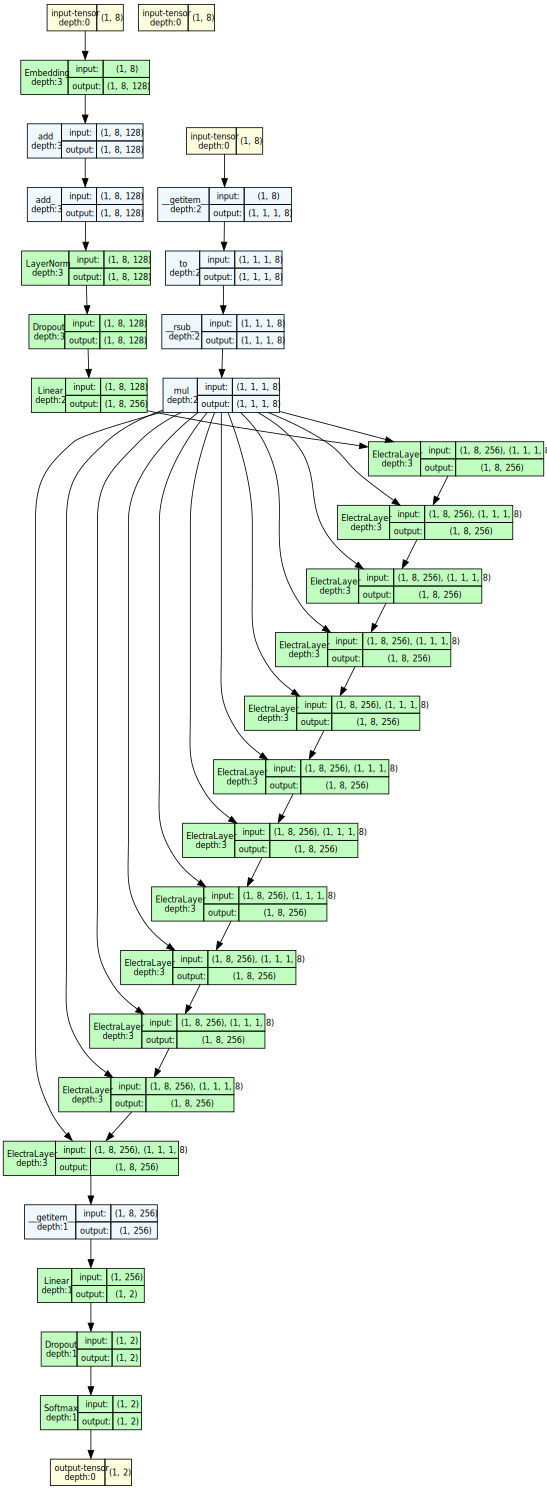

In [64]:
model_graph.visual_graph